In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
fn = 'orders.csv'
df = pd.read_csv(fn)

In [3]:
df[df['discount']<0].head(5)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
83,NaN,История государства Российского,777.00,1,2017-03-19 03:21:08,-1277.00,196964,601703,2,1556.00,195867
84,NaN,100 любимых стихов и 100 любимых сказок для ма...,500.00,1,2017-03-19 03:21:08,-1277.00,191129,601703,2,1556.00,195867
190,NaN,"Кыш, Двапортфеля и целая неделя. Кыш и я в Кры...",437.00,1,2017-03-18 11:15:09,-823.00,198440,601300,2,1102.00,910987
191,NaN,В Стране Вечных Каникул. Саша и Шура (вес: 640...,386.00,1,2017-03-18 11:15:09,-823.00,200733,601300,2,1102.00,910987
376,NaN,Первый учебник малыша. От 6 месяцев до 3 лет,376.00,1,2017-03-17 10:15:09,-564.00,204137,600758,2,843.00,910569


Задача - кластеризовать пользователей по признакам - 
* кол-во заказов, 
* кол-во купленных книг, 
* среднее/min/max кол-во книг в заказе, 
* средняя/min/max стоимость заказа, 
* средняя/min/max стоимость книги в заказе
* средний/min/max размер скидки в процентах (предварительно перевести в флоат, заполнить пустые значения нулями)
* суммарная стоимость

    вычистим датасет от явных нарушений

In [4]:
df[df.duplicated()]
df = df.drop_duplicates()
df['DISCOUNT_VALUE'] = df['DISCOUNT_VALUE'].replace('[\%]','',regex=True).astype(float).fillna(0.0)
df=df.dropna(subset=["NAME"])
df.describe()

,DISCOUNT_VALUE,PRICE,QUANTITY,discount,itemID,orderID,ordered_item_count,price,user_id
count,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00
mean,17.72,242.66,1.65,519.42,562130.60,662757.87,12.15,2797.26,641013.09
std,11.26,260.45,5.05,1032.43,557124.10,37746.45,19.61,7586.31,386438.73
min,0.00,0.00,1.00,-1963.00,131823.00,597731.00,1.00,1.00,3.00
25%,7.04,92.00,1.00,175.00,178534.00,630533.00,4.00,1053.00,194841.00
50%,19.92,185.67,1.00,313.00,196485.00,662686.00,7.00,1389.00,911644.00
75%,24.16,313.00,1.00,537.00,727802.00,694208.00,13.00,2276.40,948489.00
max,94.02,19792.18,500.00,23851.00,1787508.00,730392.00,277.00,386495.00,998104.00


In [5]:
"""
формула рассчета изначальной цены за книгу (без скидки)
"""
def book_price(price, discount):
    #price = nominal_price - (nominal_price/100) * discount
    #price = nominal_price * (1 - discount/100)
    nominal_price = price/(1 - discount/100)
    return round(nominal_price)

In [6]:
df['BOOK_PRICE'] = book_price(df['PRICE'], df['DISCOUNT_VALUE'])

In [7]:
df_res = df.groupby('user_id').agg({'DISCOUNT_VALUE': ['min', 'max' , 'mean'],
                           'BOOK_PRICE': ['min', 'max' , 'mean'],
                           'QUANTITY': ['min', 'max' , 'mean', 'sum'],
                           'price' : ['sum', 'count']
                          })

In [8]:
df_res.columns = ['_'.join(a).lower() for a in df_res.columns.tolist()]


In [9]:
features = df_res.columns
df_res.reset_index(inplace=True)

отмасштабируем и приведем к матричному виду

In [10]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
vec = scaler.fit_transform(df_res[features])

проверим дисперсию 

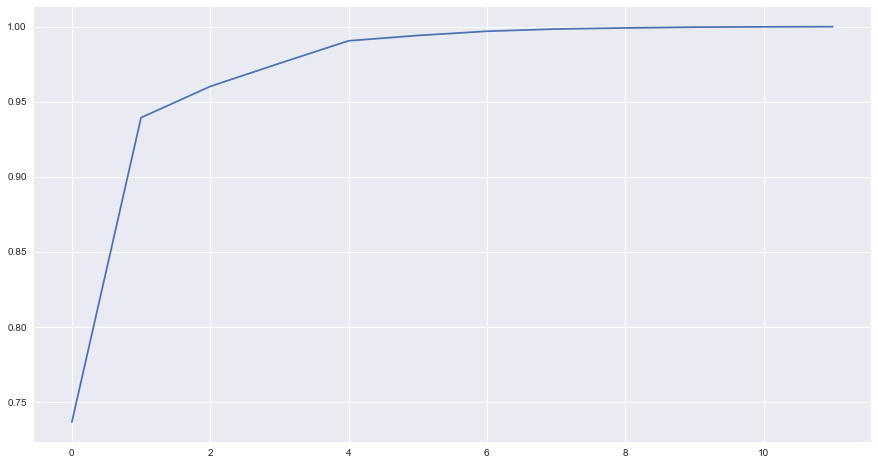

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(vec)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

в принципе даже 2 признака покрывают 95% записей

In [12]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(vec)
X_reduced.shape

(76258, 2)

In [13]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

X = X_reduced
# Compute DBSCAN
db = DBSCAN(eps=0.003, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))


Estimated number of clusters: 539


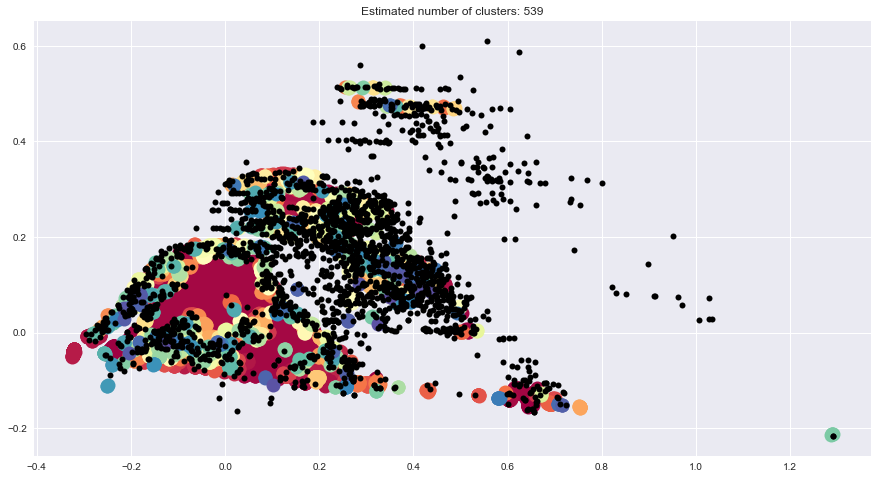

In [14]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()